In [21]:
import sys
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import numpy as np
import datetime as dt
import geopandas as gpd
import dendropy
import csv
from shapely.geometry import Point
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from pyproj import Proj,transform
import tqdm
import pandas as pd
from matplotlib import cm
import matplotlib
import matplotlib.ticker as plticker
import os
from statsmodels.stats.proportion import proportion_confint
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from datetime import date
import datetime
import csv
import baltic as bt
import collections
import math
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
# from Bio.Alphabet import IUPAC
# from pySankey.sankey import sankey

import scipy
import matplotlib as mpl
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.collections import PatchCollection
from epiweeks import Week, Year
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 18}
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 30})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
background_map = gpd.read_file("../CONT_PHY_MPOX_DEC/gadm41_NGA_2-2.json") #put the path your geojson in here - I recommend getting one from gadm.org.
#if you need to join different ones together, read them in like above, and then you can join them together like normal pandas dataframes.
#print(background_map)
background_map = background_map.to_crs("4326") #in the brackets you need to put in what coordinate system your sequences are in.
#it's usually EPSG:3395 or EPSG:4326 - if for DRC it's like -4.03,21.75 then it's EPSG:4326, if it's a higher number, try EPSG:3395
#if your dots end up in weird places, let me know because it's likely to do with this
kenya = background_map.loc[background_map["COUNTRY"] == "Nigeria"]
#print(k)x

In [3]:
#these convert dates between each other and can be useful

def true_date(date):
    
    year = str(date).split(".")[0]
    decimal = f'0.{str(date).split(".")[1]}'
    
    if year == '2019' or year == '2020'or year == '2017'or year == '2023' or year == '2018'or year == '2020'or year == '2021' or year == '2022':
        day_no = float(decimal) * 366
    else:
        day_no = float(decimal) * 365
        
    delta = dt.timedelta(day_no)
    
    start = dt.date(year=int(year), month=1, day=1)
    tr_date = start + delta
    
    return str(tr_date)

def decimal_date(date):
    
    if type(date) == str:
        date = dt.datetime.strptime(date,"%Y-%m-%d").date()
    year = date.year
    if year == 2020:
        div = 366
    else:
        div = 365
    start = dt.date(year=year, month=1, day=1)
    decimal = (date - start).days/div
    
    dec_date = year + decimal
    return dec_date

In [5]:
mcc_file = "../CONT_PHY_MPOX_DEC/CONT_PHY_MPOX_DEC.mcc.tree" #input your mcc tree here
most_recent_sample = 2023.4109589041095 #most recent sample in decimal format [you can get this from Beauti]

tree = dendropy.Tree.get(path=mcc_file, schema="nexus")

#first, name all of the nodes - currently all internal nodes don't have name
count = 0
for node in tree.preorder_node_iter():
    count += 1
    node.label = count

In [6]:
#then extract info from the tree and write it to a file - you only need to run this function once
#commented out sections are for if you want to know where the nodes fall in terms of a country for eg. You don't need it for plotting
edge_dict = defaultdict(dict)
write_file = '../CONT_PHY_MPOX_DEC/3CONT_ACEGID_Mpox_phylo.csv'
point_lst = []
# location_col_name = "" #in here, add what the name of the location column in the background map geojson is eg country

with open(write_file, 'w') as fw:
#     writer = csv.DictWriter(fw, fieldnames=["node1","node2","length","start_long","start_lat","end_lat", "end_long", "start_location", "end_location", "start_dec_date", "end_dec_date", "start_real_date", "end_real_date"])
    writer = csv.DictWriter(fw, fieldnames=["node1","node2","length","start_long","start_lat","end_lat", "end_long", "start_dec_date", "end_dec_date", "start_real_date", "end_real_date", 'end_location', 'start_location'])
    writer.writeheader()

    count = 0
    for edge in tqdm.tqdm(tree.postorder_edge_iter()):
        write_dict = {}
        if edge.tail_node:
            count += 1
            edge_dict[count] = {}
            node1 = edge.tail_node
            node2 = edge.head_node
            length = edge.length
            annotation_dict = node2.annotations.values_as_dict()
            if 'location1' not in annotation_dict:
                for key, value in annotation_dict.items():
                    for i in value:
                        if "location1" in i:
                            end_lat = i.split("=")[1]
                        elif "location2" in i:
                            end_long = i.split("=")[1]
                
            else:
                start_lat = node1.annotations['location1'].value
                start_long = node1.annotations['location2'].value
                end_lat = node2.annotations['location1'].value
                end_long = node2.annotations['location2'].value
            
            start_dec_date = most_recent_sample - float(node1.annotations['height'].value)
            end_dec_date = most_recent_sample - float(node2.annotations['height'].value)
            start_real_date = true_date(start_dec_date)
            end_real_date = true_date(end_dec_date)


            if end_lat == "" or end_long == "":
                print(node2)
                for i in node2.annotations:
                    print(i)
                    
                    
                    
# this section is for if you want to know where the nodes fall in terms of eg country. 
            start_loc = None
            end_loc = None

            start_point = Point(float(start_long), float(start_lat))
            end_point = Point(float(end_long), float(end_lat))
            point_lst.append((start_point, end_point))

            for location, polygon in zip(background_map["NAME_1"], background_map["geometry"]):
                if polygon.contains(start_point):
                    start_loc = location
                if polygon.contains(end_point):
                    end_loc = location
                if start_loc and end_loc:
                    break



            write_dict["node1"] = node1.label
            write_dict['node2'] = node2.label
            write_dict["length"] = length

            write_dict["start_lat"] = start_lat
            write_dict["start_long"] = start_long
            write_dict["end_lat"] = end_lat
            write_dict["end_long"] = end_long

            write_dict["start_location"] = start_loc
            write_dict["end_location"] = end_loc

            write_dict["start_dec_date"] = start_dec_date
            write_dict["end_dec_date"] = end_dec_date
            write_dict["start_real_date"] = start_real_date
            write_dict["end_real_date"] = end_real_date
            

            writer.writerow(write_dict)

369it [00:01, 328.08it/s]


In [7]:
def pull_from_existing_file(results_file):
    edge_dict = defaultdict(dict)
    with open(results_file) as f:
        count = 0
        data = csv.DictReader(f)
        for l in data:
            count += 1
            edge_dict[count] = {}
            edge_dict[count]["start_lat"] = float(l['start_lat'])
            edge_dict[count]["start_long"] = float(l['start_long'])
            edge_dict[count]["end_lat"] = float(l['end_lat'])
            edge_dict[count]['end_long'] = float(l['end_long'])
            edge_dict[count]["start_dec_date"] = float(l['start_dec_date'])
            edge_dict[count]["end_dec_date"] = float(l['end_dec_date'])
            edge_dict[count]["start_real_date"] = l['start_real_date']
            edge_dict[count]["end_real_date"] = l['end_real_date']

            edge_dict[count]["length"] = l['length']
            
    edge_dict_sorted = {k:v for k,v in sorted(edge_dict.items(), key=lambda item: item[1]["end_dec_date"],reverse=True)}
            
    return edge_dict_sorted

results_file = '../CONT_PHY_MPOX_DEC/3CONT_ACEGID_Mpox_phylo.csv'
edge_dict = pull_from_existing_file(results_file)

In [8]:
#this will colour the nodes by date.

dates = []
for edge, edgedict in edge_dict.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])

    
norm = matplotlib.colors.Normalize(vmin=min(dates), vmax=max(dates))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#484C7E","#FE6362", "#FFD544"]) #start, mid and end point of the colour map - you can change them whatever you like
colour_dict = {}
for date in dates:
    colour_dict[date] = cmap(norm(date))

100%|██████████| 368/368 [00:02<00:00, 152.31it/s]


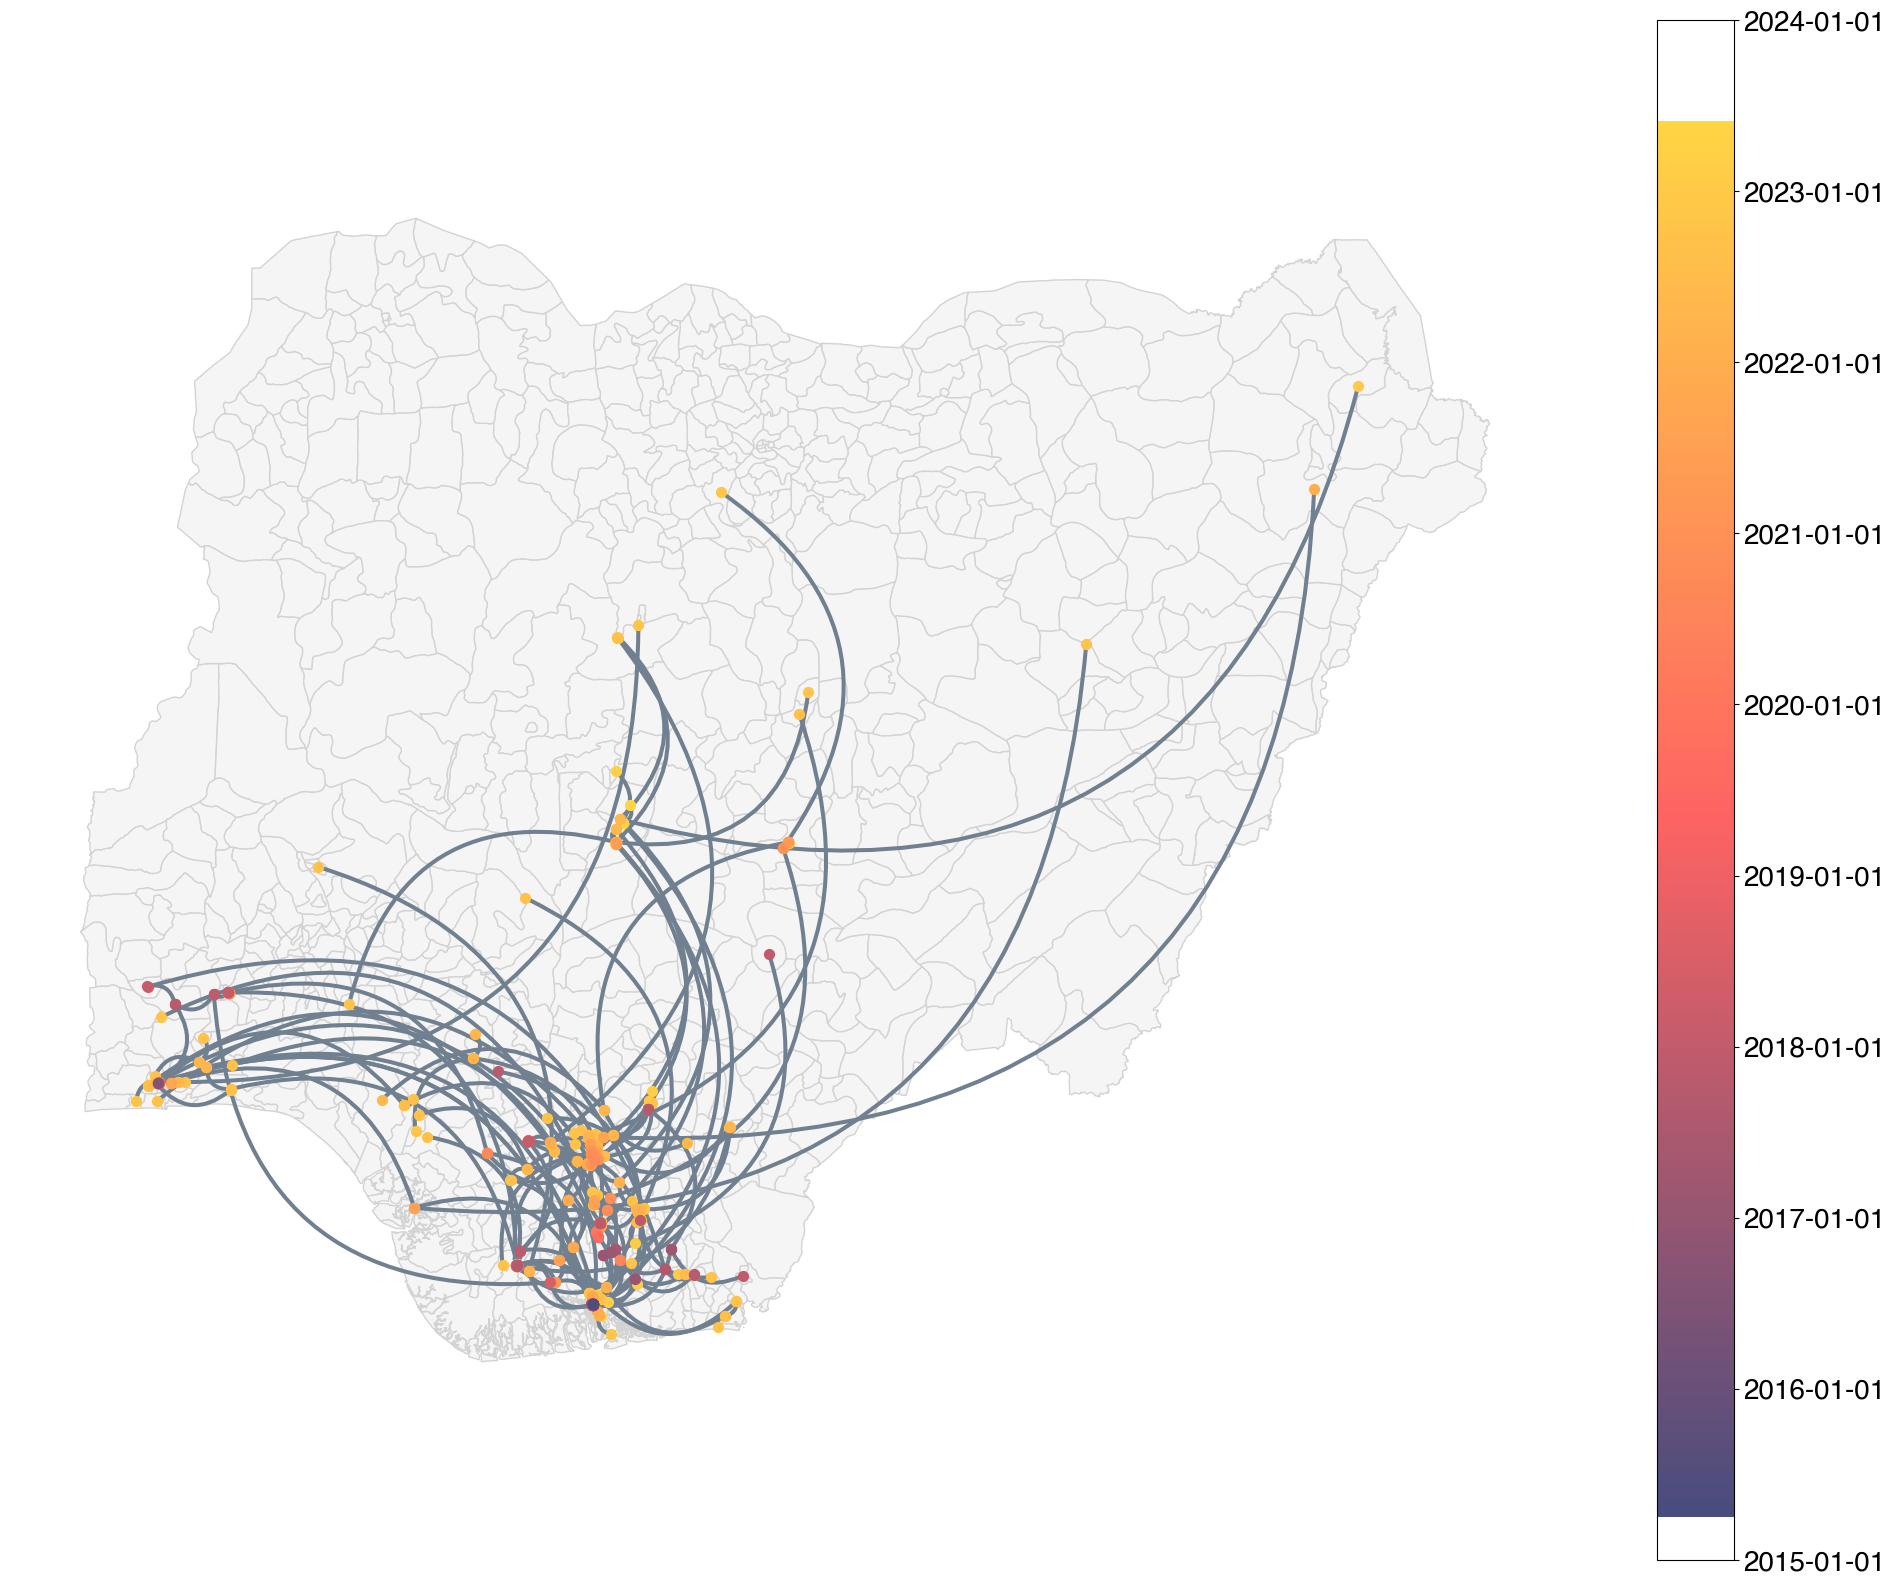

In [12]:
fig, ax = plt.subplots(1,1, figsize=(25,20))
matplotlib.rcParams.update({'font.size': 20})
#background_map["geometry"] = background_map.geometry.simplify(1000) #this smooths some edges so it's not too detailed for pdf readers

background_map.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey") #this plots the background layer ie the shape of the countries
bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
new_ticks = []
    
for i in bar.get_ticks():
    new_ticks.append(true_date(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
for edge, edgedict in tqdm.tqdm(edge_dict.items()): #loop through every branch and draw two dots and a line

    point_dict = defaultdict(list)

    A = edgedict["start_long"],edgedict["start_lat"]
    B = edgedict["end_long"],edgedict["end_lat"]
    start_date = edgedict["start_dec_date"]
    end_date = edgedict["end_dec_date"]

    #draw the line
    kw = dict(color="slategrey",linewidth=2.9)
    liney = mpatches.FancyArrowPatch(A, B, arrowstyle="-",
                             connectionstyle="arc3,rad=.5", **kw)
    ax.add_patch(liney)
    
    
        
    #draw the dots
    ax.scatter(A[0], A[1], s=50, color=colour_dict[start_date], alpha=1.0, zorder=5)
    ax.scatter(B[0], B[1], s=50, color=colour_dict[end_date], alpha=1.0, zorder=6)

ax.axis('off')
'3CONT_ACEGID_Mpox_phylo.csv'
plt.savefig(f"../CONT_PHY_MPOX_DEC/1mpox_continuous_phylogeography_map.png", bbox_inches='tight')
plt.savefig(f"../CONT_PHY_MPOX_DEC/1mpox_continuous_phylogeography_map.pdf", bbox_inches='tight')
plt.savefig(f"../CONT_PHY_MPOX_DEC/1mpox_continuous_phylogeography_map.svg", bbox_inches='tight')

In [14]:
from math import radians, cos, sin, asin, sqrt
def calc_distance(long1,lat1,long2,lat2):
    
     
    # radians which converts from degrees to radians.
    long1 = radians(long1)
    long2 = radians(long2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [15]:
Lagos = (-0.1257,51.51)
Ondo = (-2.244, 53.484)

print(calc_distance(Lagos[0], Lagos[1], Ondo[0], Ondo[1]))

262.162946805854


In [18]:
 
fw = open(f"../CONT_PHY_MPOX_DEC/mpox_movements.csv", 'w')
fw.write(f"date,distance\n")
with open(os.path.join("../CONT_PHY_MPOX_DEC/3CONT_ACEGID_Mpox_phylo.csv")) as f:
    data = csv.DictReader(f)
    for line in data:
        if line["start_long"] != line["end_long"]:

            start = (float(line['start_long']),float(line["start_lat"]))
            end = (float(line['end_long']),float(line["end_lat"]))

            distance = calc_distance(start[0],start[1],end[0],end[1])

            fw.write(f'{line["start_real_date"]},{distance}\n')

fw.close()     

100%|██████████| 368/368 [00:00<00:00, 125682.26it/s]


2015-04-03


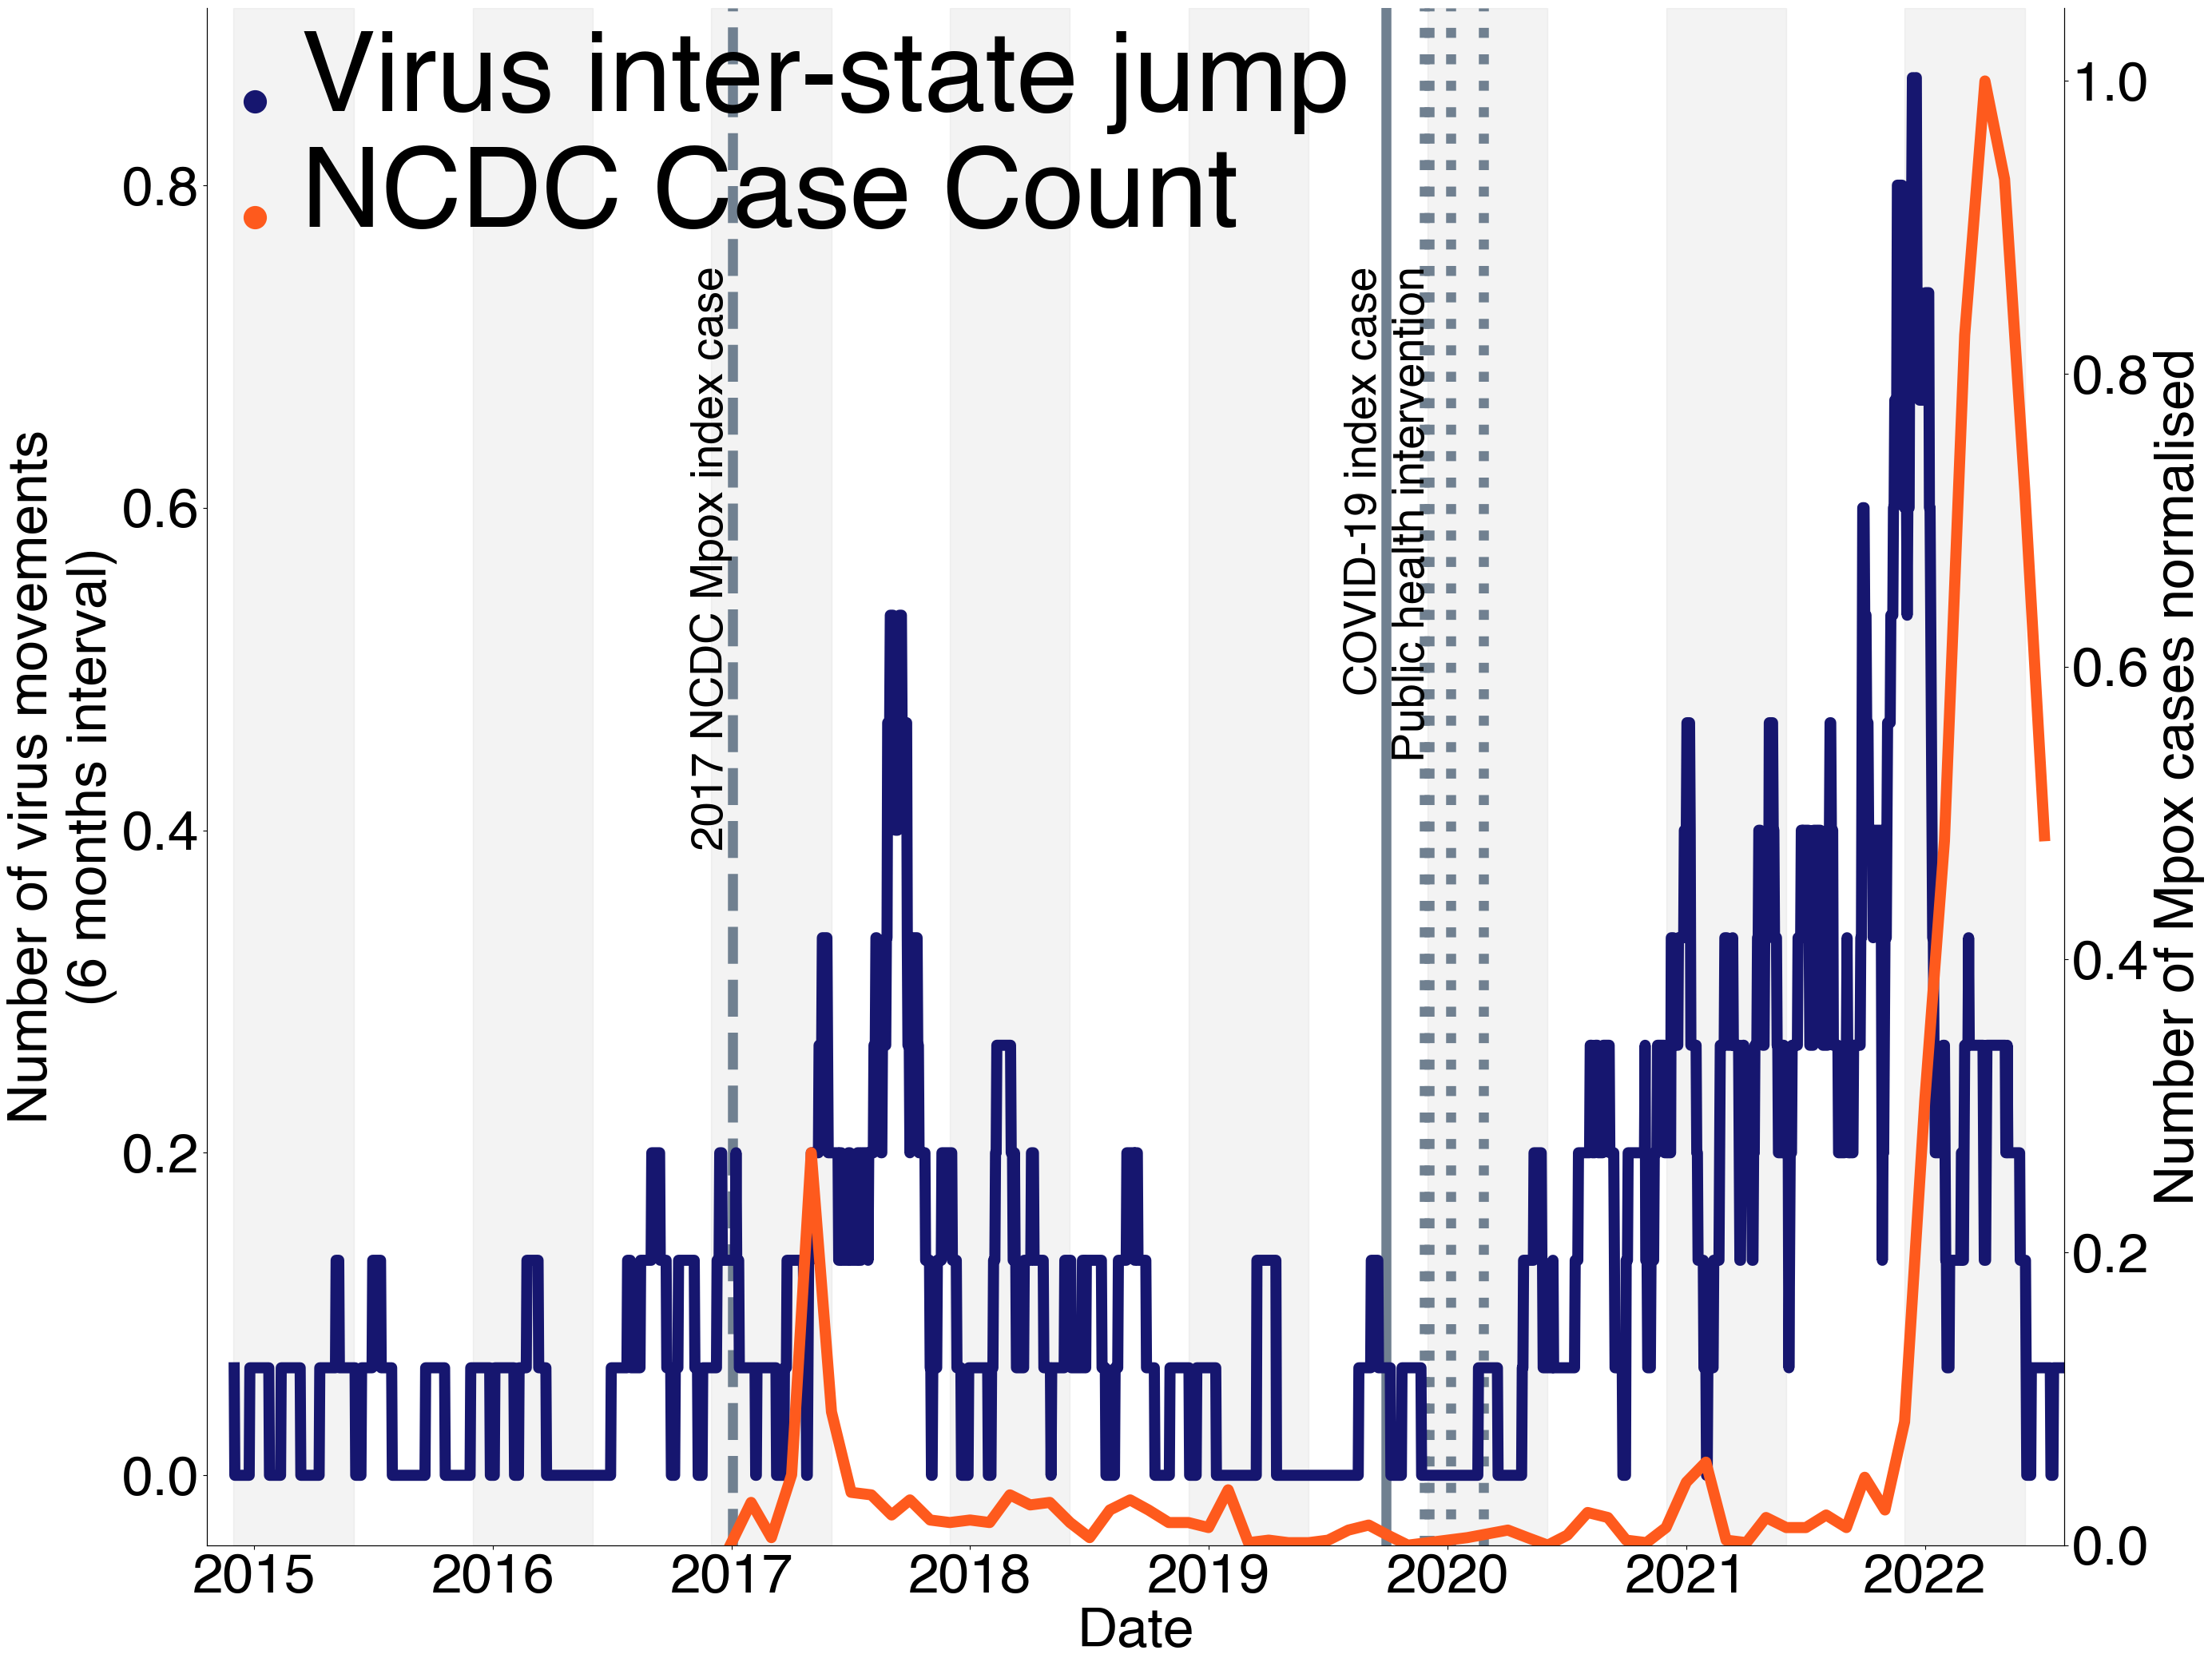

In [26]:
edge_dict_Nigeria = pull_from_existing_file("../CONT_PHY_MPOX_DEC/3CONT_ACEGID_Mpox_phylo.csv")

# Create a custom legend handle with a circle marker
circle_handle = mlines.Line2D([], [], color='black', marker='o', markersize=15, label='Circle Label', linestyle='None')

matplotlib.rcParams.update({'font.size': 40})

# Load the raw cases data
raw_cases = pd.read_csv('../DTA_MPOX_DEC/1totalMpox_NCDC_cases.csv')

# Normalize the 'cases' column
scaler = MinMaxScaler()
raw_cases['cases_normalized'] = scaler.fit_transform(raw_cases['cases'].values.reshape(-1, 1))

# Convert the 'date' column to datetime
raw_cases['date'] = pd.to_datetime(raw_cases['date'])

# Sum the cases across all states for each date
summed_cases_by_date = raw_cases.groupby('date')['cases'].sum().reset_index()

# Normalize the summed cases
scaler = MinMaxScaler()
summed_cases_by_date['normalized_cases'] = scaler.fit_transform(summed_cases_by_date['cases'].values.reshape(-1, 1))


register_matplotlib_converters()
key_dates = [dt.date(2017,6,30), dt.date(2020,2,27), dt.date(2020,3,18), dt.date(2020,4,26), dt.date(2020,5,4),  dt.date(2020,6,6)]
virus_movements = {}
between_pc_mvmts = {}
for edge,edgedict in tqdm.tqdm(edge_dict_Nigeria.items()):
    #print(edgedict['start_real_date'])
    date = dt.datetime.strptime(edgedict['start_real_date'], "%Y-%m-%d").date()
    if date not in virus_movements:
        virus_movements[date] = 1
    else:
        virus_movements[date] += 1
        
    if edgedict["start_long"] != edgedict["end_long"]:
        if date not in between_pc_mvmts:
            between_pc_mvmts[date] = 1
        else:
            between_pc_mvmts[date] += 1
                
first_date = min(virus_movements)
last_date = max(virus_movements)
print(first_date)   
day = dt.timedelta(1)
date = first_date

for i in range((last_date - first_date).days):
    new_date = date + day
    if new_date not in virus_movements:
        virus_movements[new_date] = 0
    if new_date not in between_pc_mvmts:
        between_pc_mvmts[new_date] = 0
    date = new_date
virus_movement_ordered = {k:v for k,v in sorted(virus_movements.items())}
between_pc_movement_ordered = {k:v for k,v in sorted(between_pc_mvmts.items())}

# Creating the DataFrame from the movement data
df_dict = defaultdict(list)
for k, v in virus_movement_ordered.items():
    df_dict["Date"].append(k)
    df_dict["Movements"].append(v)
    df_dict["Between_PC"].append(between_pc_movement_ordered[k])

df = pd.DataFrame(df_dict)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['7 day rolling'] = df.Movements.rolling(30).mean()
df['7 day rolling between pc'] = df.Between_PC.rolling(30).mean()

new_last_date = dt.date(2022, 12, 1)
first_mvmt = dt.date(2015, 4, 20)


# Merge the normalized cases data with the existing movement data
df = df.merge(raw_cases[['date', 'cases_normalized']], how='left', left_index=True, right_on='date')
df.set_index('date', inplace=True)

# Get dates at 6-month intervals
six_month_intervals = pd.date_range(start=first_mvmt, end=new_last_date, freq='6MS')

# Plot configuration
matplotlib.rcParams.update({'font.size': 50})
fig, ax = plt.subplots(1, 1, figsize=(30, 25))
ax2 = ax.twinx()

# Define vertical lines with properties
vertical_lines = [
    {"date": dt.date(2017, 6, 3), "color": "slategrey", "linestyle": "--", "linewidth": 9, "label": "2017 NCDC Mpox index case"},
    {"date": dt.date(2020, 2, 27), "color": "slategrey", "linestyle": "-", "linewidth": 9, "label": "COVID-19 index case"},
    {"date": dt.date(2020, 4, 26), "color": "slategrey", "linestyle": ":", "linewidth": 9, "label": "Public health intervention"},
    {"date": dt.date(2020,5,4), "color": "slategrey", "linestyle": ":", "linewidth": 9, "label": "Public health intervention"},
    {"date": dt.date(2020, 6, 6), "color": "slategrey", "linestyle": ":", "linewidth": 9, "label": "Public health intervention"},
    {"date": dt.date(2020, 7, 26), "color": "slategrey", "linestyle": ":", "linewidth": 9, "label": "Public health intervention"}
]

# Add vertical lines to the plot without adding them to the legend
for line in vertical_lines:
    ax.axvline(x=line["date"], color=line["color"], linestyle=line["linestyle"], linewidth=line["linewidth"])
    
    y_pos = ax.get_ylim()[1] * 0.75  

    if line["label"] == "Public health intervention":
        # Adjust these values as needed to position your label
        x_pos = mdates.date2num(line["date"])  
        padding = 15  
        
        
        adjusted_x_pos = mdates.num2date(x_pos + padding)  # Convert back to datetime
        
        if line["date"] == dt.date(2020, 4, 26):  # Change this date to match the first "Public health intervention" date
            ax.text(x=adjusted_x_pos, y=y_pos, s="Public health intervention", color="black", rotation=90, verticalalignment='top', horizontalalignment='right', fontsize=40)
    else:
        # Add the label without padding adjustment
        ax.text(x=line["date"], y=y_pos, s=line["label"], color="black", rotation=90, verticalalignment='top', horizontalalignment='right', fontsize=40)

# Plotting the lines for the movements
line3 = ax.plot(df.index, df['7 day rolling'], color="#16166F", linewidth=10, label="Virus inter-state jump")
line4 = ax2.plot(summed_cases_by_date['date'], summed_cases_by_date['normalized_cases'], linewidth=10, color="#FE5A1D", label='NCDC Case Count')



for i in range(len(six_month_intervals) - 1):
    # Draw a vertical span (interval) for every second 6-month period
    if i % 2 == 0:  # This checks if the index is even
        ax.axvspan(six_month_intervals[i], six_month_intervals[i + 1], color='grey', alpha=0.09)
        
ax.set_ylabel("Number of virus movements\n(6 months interval)")
ax2.set_ylabel("Number of Mpox cases normalised")
ax.set_xlabel("Date")

#Set x-axis to show months and format it
ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Set x-axis limits
ax.set_xlim(first_mvmt - dt.timedelta(days=30), new_last_date + dt.timedelta(days=30))
ax.tick_params(axis='x',grid_lw=20)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

virus_jump_handle = mlines.Line2D([], [], color='#16166F', marker='o', markersize=20, linestyle='None', label='Virus inter-state jump')
ncdc_case_count_handle = mlines.Line2D([], [], color='#FE5A1D', marker='o', markersize=20, linestyle='None', label='NCDC Case Count')


legend = ax.legend(handles=[virus_jump_handle, ncdc_case_count_handle], fontsize=23, frameon=False, loc='upper left')

# Customize the legend text as needed
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_fontsize('100')



[ax.spines[loc].set_visible(False) for loc in ['top']]
[ax2.spines[loc].set_visible(False) for loc in ['top']]
plt.ylim(0)
plt.savefig("../CONT_PHY_MPOX_DEC/major_mpox_virus_movements.pdf", bbox_inches='tight')
plt.savefig("../CONT_PHY_MPOX_DEC/major_mpox_virus_movements.png", bbox_inches='tight')
plt.savefig("../CONT_PHY_MPOX_DEC/major_mpox_virus_movements.svg", bbox_inches='tight')

plt.show()

In [34]:
date_to_movements = defaultdict(list)
with open("../CONT_PHY_MPOX_DEC/mpox_movements.csv") as f:
    data = csv.DictReader(f)
    for l in tqdm.tqdm(data):
        date = dt.datetime.strptime(l['date'], "%Y-%m-%d").date()
        date_to_movements[date].append(float(l['distance']))
        #print(l['date'])
sorted_mvmts = {k:v for k,v in sorted(date_to_movements.items(), key=lambda item: item[0])}

month_mvmts = defaultdict(list)
all_month_mvmts = defaultdict(list)
for day, dists in sorted_mvmts.items():
    to_add = []
    for i in dists:
        if i >= 10:
            to_add.append(i)
    
    month_mvmts[day.month].extend(to_add)
    all_month_mvmts[day.month].extend(dists)
    
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

368it [00:00, 86689.35it/s]


In [35]:
first_date = dt.date(2017, 9,22)
second_date = dt.date(2020,6,23)

lockdown_mvmts = defaultdict(list)

for date, mvmts in sorted_mvmts.items():     
    if date < first_date:
        for i in mvmts:
            if i > 50:
                lockdown_mvmts["Before NCDC 2017 primary case"].append(i)
    elif date >= first_date and date < second_date:
        for i in mvmts:
            if i > 50:
                lockdown_mvmts["COVID Lockdown"].append(i)
    elif date >= second_date:
        for i in mvmts:
            if i > 50:
                lockdown_mvmts["After Lockdown"].append(i)
    else:
        print(date,mvmts)

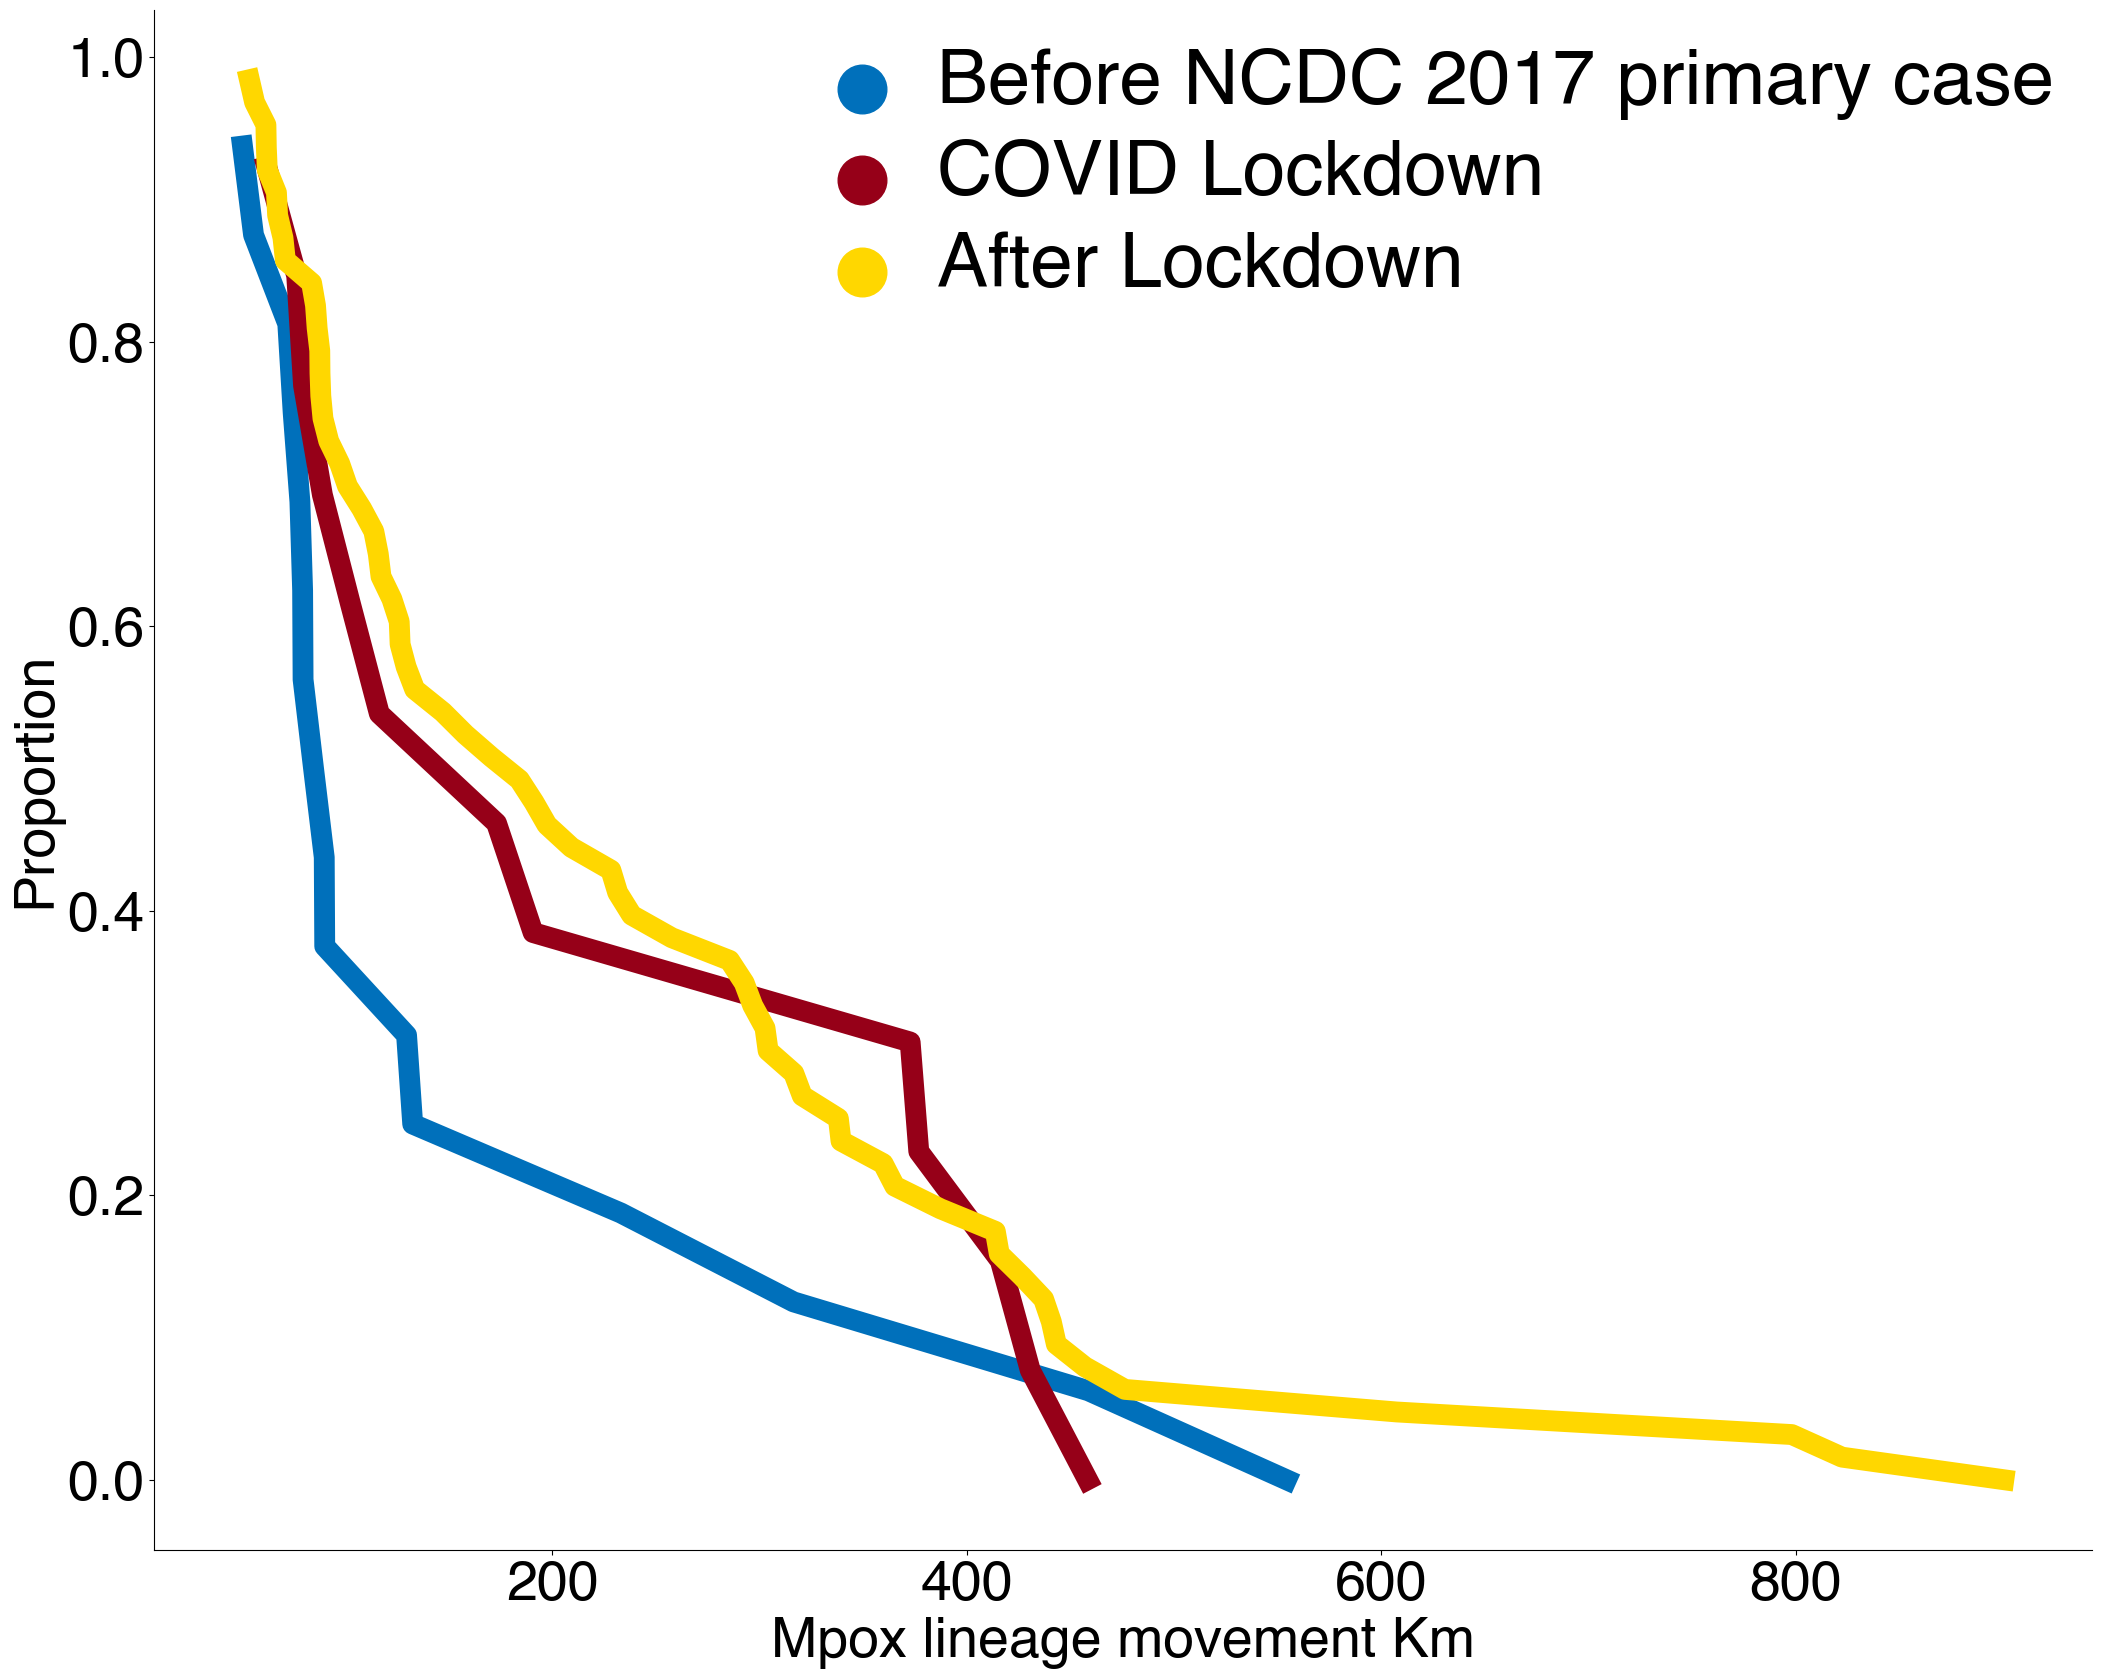

In [36]:
fig, ax = plt.subplots(1,1, figsize=(25,20))
matplotlib.rcParams.update({'font.size': 40})

colours = {"Before NCDC 2017 primary case":"#0070BB", "COVID Lockdown":"#960018", "After Lockdown":"#FFD700"}

for period, data in lockdown_mvmts.items():
    
                
        x,y = ecdf(data)

        reverse = []
        for i in y:
            reverse.append(1-i)

        ax.plot(x, reverse, label=period, linewidth=15, color=colours[period]) 


# Create custom legend handles with circle markers
primary_case = mlines.Line2D([], [], color='#0070BB', marker='o', markersize=35, linestyle='None', label='Before NCDC 2017 primary case')
COVID_Lockdown = mlines.Line2D([], [], color='#960018', marker='o', markersize=35, linestyle='None', label='COVID Lockdown')
After_Lockdown = mlines.Line2D([], [], color='#FFD700', marker='o', markersize=35, linestyle='None', label='After Lockdown')

# After plotting your lines and data
# Update the legend to include the custom circle handles
legend = ax.legend(handles=[primary_case, COVID_Lockdown, After_Lockdown], fontsize=30, frameon=False, loc='upper right')

# Customize the legend text as needed
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_fontsize('55')


        

#ax.legend(frameon=False)
ax.set_xlabel("Mpox lineage movement Km", fontweight='bold')
ax.set_ylabel("Proportion",  fontweight='bold')
[ax.spines[loc].set_visible(False) for loc in ['top', 'right']]
plt.savefig("../CONT_PHY_MPOX_DEC/1movement_length_over_time.pdf", bbox_inches='tight')
plt.savefig("../CONT_PHY_MPOX_DEC/1movement_length_over_time.png", bbox_inches='tight')
plt.savefig("../CONT_PHY_MPOX_DEC/1movement_length_over_time.svg", bbox_inches='tight')


plt.show()